# GANs For Art

## Importing the modules

In [ ]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the data

In [ ]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="Z:/ArtGenerator/Resized_color256x512",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

In [ ]:
images,_ = train_ds[382]
print(images.size())
plt.imshow(images.permute(1,2,0))

In [ ]:
images,_ = train_ds[872]
plt.imshow(images.permute(1,2,0))

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

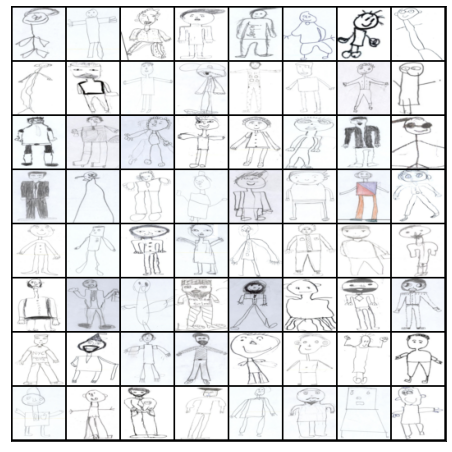

In [8]:
show_batch(train_dl)

In [9]:
torch.cuda.is_available()

True

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 150

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Defining the model

torch.Size([128, 3, 64, 64])


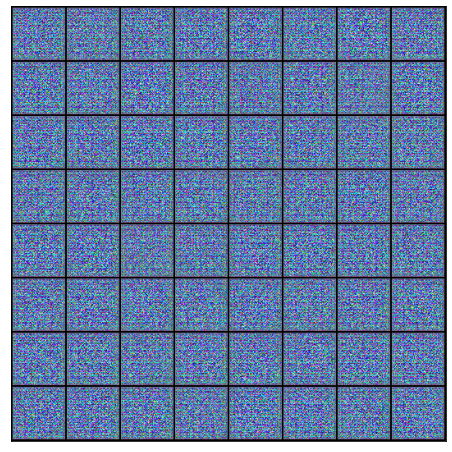

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


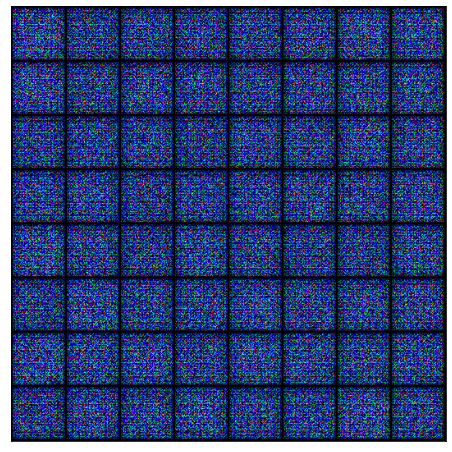

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.001
epochs = 150

In [29]:
history = fit(epochs,lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 14.8959, loss_d: 0.0786, real_score: 0.9324, fake_score: 0.0000
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 3.8088, loss_d: 0.0516, real_score: 0.9963, fake_score: 0.0465
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 3.5141, loss_d: 0.1228, real_score: 0.9993, fake_score: 0.1129
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 5.7306, loss_d: 0.0089, real_score: 0.9969, fake_score: 0.0057
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 4.7832, loss_d: 0.0206, real_score: 0.9955, fake_score: 0.0159
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 2.8584, loss_d: 0.0937, real_score: 0.9946, fake_score: 0.0839
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 2.9798, loss_d: 0.5880, real_score: 0.9993, fake_score: 0.4036
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 1.8062, loss_d: 1.0387, real_score: 0.4940, fake_score: 0.0912
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 3.3231, loss_d: 0.4643, real_score: 0.9047, fake_score: 0.1804
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 7.6848, loss_d: 1.5964, real_score: 0.2845, fake_score: 0.0006
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 4.9215, loss_d: 1.3093, real_score: 0.9100, fake_score: 0.6510
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 1.8341, loss_d: 1.4577, real_score: 0.3794, fake_score: 0.2279
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 2.4025, loss_d: 0.6384, real_score: 0.6717, fake_score: 0.1685
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 1.8711, loss_d: 2.1081, real_score: 0.1956, fake_score: 0.0277
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 4.0635, loss_d: 0.2637, real_score: 0.8882, fake_score: 0.1254
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 3.1260, loss_d: 0.7532, real_score: 0.7524, fake_score: 0.3290
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 6.5914, loss_d: 0.9918, real_score: 0.9033, fake_score: 0.5645
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 2.4377, loss_d: 0.4750, real_score: 0.8377, fake_score: 0.2364
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 1.8470, loss_d: 0.7119, real_score: 0.8326, fake_score: 0.3738
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 5.4851, loss_d: 1.8589, real_score: 0.9926, fake_score: 0.7747
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 1.5394, loss_d: 1.0519, real_score: 0.4866, fake_score: 0.1998
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 2.2942, loss_d: 0.8064, real_score: 0.9597, fake_score: 0.5156
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 1.7120, loss_d: 0.9330, real_score: 0.9603, fake_score: 0.5663
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 1.4364, loss_d: 0.2916, real_score: 0.8836, fake_score: 0.1430
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 3.8801, loss_d: 0.8089, real_score: 0.8135, fake_score: 0.4066
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 0.3469, loss_d: 1.8338, real_score: 0.2360, fake_score: 0.0077
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 6.0622, loss_d: 0.9461, real_score: 0.8495, fake_score: 0.4962
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 2.4710, loss_d: 0.5221, real_score: 0.7539, fake_score: 0.1841
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 3.1853, loss_d: 0.9115, real_score: 0.9881, fake_score: 0.5467
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 6.5137, loss_d: 0.8625, real_score: 0.8412, fake_score: 0.4503
Saving generated-images-0030.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 4.8874, loss_d: 6.4678, real_score: 0.0029, fake_score: 0.0002
Saving generated-images-0031.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 5.9362, loss_d: 1.4401, real_score: 0.8179, fake_score: 0.6695
Saving generated-images-0032.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 2.5792, loss_d: 0.4823, real_score: 0.8349, fake_score: 0.2354
Saving generated-images-0033.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 3.8551, loss_d: 0.1718, real_score: 0.9535, fake_score: 0.1032
Saving generated-images-0034.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 2.8770, loss_d: 0.6874, real_score: 0.9787, fake_score: 0.4554
Saving generated-images-0035.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 7.1043, loss_d: 0.7497, real_score: 0.9412, fake_score: 0.4732
Saving generated-images-0036.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 5.0841, loss_d: 0.4478, real_score: 0.9543, fake_score: 0.3188
Saving generated-images-0037.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 3.4544, loss_d: 0.1740, real_score: 0.8873, fake_score: 0.0421
Saving generated-images-0038.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 0.6712, loss_d: 0.6788, real_score: 0.6371, fake_score: 0.1597
Saving generated-images-0039.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 2.4295, loss_d: 0.4185, real_score: 0.8544, fake_score: 0.2092
Saving generated-images-0040.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 4.0969, loss_d: 0.6092, real_score: 0.9263, fake_score: 0.3987
Saving generated-images-0041.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 4.0022, loss_d: 0.2800, real_score: 0.8286, fake_score: 0.0525
Saving generated-images-0042.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 2.3426, loss_d: 0.6375, real_score: 0.9011, fake_score: 0.3881
Saving generated-images-0043.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 5.6907, loss_d: 0.3848, real_score: 0.9216, fake_score: 0.2222
Saving generated-images-0044.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 3.8947, loss_d: 2.0723, real_score: 0.2392, fake_score: 0.0003
Saving generated-images-0045.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 2.1311, loss_d: 1.3979, real_score: 0.3593, fake_score: 0.0084
Saving generated-images-0046.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 4.0989, loss_d: 0.5732, real_score: 0.8372, fake_score: 0.2642
Saving generated-images-0047.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 2.5561, loss_d: 0.9846, real_score: 0.4521, fake_score: 0.0275
Saving generated-images-0048.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 2.7730, loss_d: 0.1031, real_score: 0.9885, fake_score: 0.0815
Saving generated-images-0049.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 4.5524, loss_d: 0.0941, real_score: 0.9640, fake_score: 0.0418
Saving generated-images-0050.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 2.2314, loss_d: 0.6101, real_score: 0.9903, fake_score: 0.4243
Saving generated-images-0051.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 3.7107, loss_d: 1.4370, real_score: 0.9951, fake_score: 0.6968
Saving generated-images-0052.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 2.8292, loss_d: 0.4609, real_score: 0.8123, fake_score: 0.1372
Saving generated-images-0053.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 2.9049, loss_d: 0.2168, real_score: 0.9660, fake_score: 0.1525
Saving generated-images-0054.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 1.5335, loss_d: 0.9429, real_score: 0.9283, fake_score: 0.4293
Saving generated-images-0055.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 1.7571, loss_d: 0.5108, real_score: 0.7068, fake_score: 0.0777
Saving generated-images-0056.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 6.3769, loss_d: 0.5290, real_score: 0.9601, fake_score: 0.3622
Saving generated-images-0057.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 6.6442, loss_d: 5.7508, real_score: 0.0060, fake_score: 0.0001
Saving generated-images-0058.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 3.0808, loss_d: 0.5786, real_score: 0.8184, fake_score: 0.2900
Saving generated-images-0059.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 4.3607, loss_d: 0.2871, real_score: 0.8910, fake_score: 0.1448
Saving generated-images-0060.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 5.9135, loss_d: 0.8054, real_score: 0.5049, fake_score: 0.0063
Saving generated-images-0061.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 6.9993, loss_d: 1.1071, real_score: 0.9618, fake_score: 0.6127
Saving generated-images-0062.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 4.5948, loss_d: 0.1970, real_score: 0.9794, fake_score: 0.1480
Saving generated-images-0063.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 3.4876, loss_d: 0.9415, real_score: 0.9561, fake_score: 0.5736
Saving generated-images-0064.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 2.5203, loss_d: 0.0851, real_score: 0.9933, fake_score: 0.0737
Saving generated-images-0065.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 4.2640, loss_d: 1.7687, real_score: 0.2649, fake_score: 0.0068
Saving generated-images-0066.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 3.3827, loss_d: 1.0494, real_score: 0.4584, fake_score: 0.0099
Saving generated-images-0067.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 3.9420, loss_d: 0.4451, real_score: 0.6934, fake_score: 0.0262
Saving generated-images-0068.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 5.4737, loss_d: 0.4610, real_score: 0.6922, fake_score: 0.0087
Saving generated-images-0069.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 2.8395, loss_d: 3.2513, real_score: 0.0790, fake_score: 0.0027
Saving generated-images-0070.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 4.0163, loss_d: 0.3903, real_score: 0.8899, fake_score: 0.2186
Saving generated-images-0071.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 3.9458, loss_d: 0.9441, real_score: 0.4627, fake_score: 0.0176
Saving generated-images-0072.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 8.7672, loss_d: 1.0928, real_score: 0.9916, fake_score: 0.6094
Saving generated-images-0073.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 4.2471, loss_d: 0.2122, real_score: 0.8685, fake_score: 0.0608
Saving generated-images-0074.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 4.5372, loss_d: 0.5646, real_score: 0.6422, fake_score: 0.0237
Saving generated-images-0075.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 2.9481, loss_d: 0.3730, real_score: 0.8632, fake_score: 0.1784
Saving generated-images-0076.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 4.0879, loss_d: 0.0642, real_score: 0.9613, fake_score: 0.0204
Saving generated-images-0077.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 5.9898, loss_d: 0.0468, real_score: 0.9666, fake_score: 0.0112
Saving generated-images-0078.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 4.0419, loss_d: 0.3458, real_score: 0.8413, fake_score: 0.1023
Saving generated-images-0079.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 5.1517, loss_d: 0.4977, real_score: 0.9283, fake_score: 0.3233
Saving generated-images-0080.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 5.2865, loss_d: 1.6091, real_score: 0.3324, fake_score: 0.0008
Saving generated-images-0081.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 9.6397, loss_d: 2.2718, real_score: 0.9495, fake_score: 0.8571
Saving generated-images-0082.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 3.1418, loss_d: 0.6122, real_score: 0.8651, fake_score: 0.3191
Saving generated-images-0083.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 4.2489, loss_d: 0.1514, real_score: 0.9477, fake_score: 0.0861
Saving generated-images-0084.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 2.9779, loss_d: 0.1105, real_score: 0.9332, fake_score: 0.0356
Saving generated-images-0085.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 5.2027, loss_d: 0.5679, real_score: 0.6249, fake_score: 0.0251
Saving generated-images-0086.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 4.0652, loss_d: 0.9387, real_score: 0.4940, fake_score: 0.0154
Saving generated-images-0087.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 3.9633, loss_d: 0.0483, real_score: 0.9811, fake_score: 0.0283
Saving generated-images-0088.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 7.0298, loss_d: 0.8259, real_score: 0.9936, fake_score: 0.5046
Saving generated-images-0089.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 4.5333, loss_d: 0.2395, real_score: 0.8738, fake_score: 0.0650
Saving generated-images-0090.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 6.7701, loss_d: 0.4520, real_score: 0.6851, fake_score: 0.0061
Saving generated-images-0091.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 12.4903, loss_d: 1.6918, real_score: 0.9748, fake_score: 0.7680
Saving generated-images-0092.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 2.9774, loss_d: 0.3191, real_score: 0.8696, fake_score: 0.1451
Saving generated-images-0093.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 5.7727, loss_d: 0.4122, real_score: 0.9036, fake_score: 0.2448
Saving generated-images-0094.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 3.5070, loss_d: 0.0577, real_score: 0.9610, fake_score: 0.0169
Saving generated-images-0095.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 5.2370, loss_d: 0.4470, real_score: 0.9088, fake_score: 0.2747
Saving generated-images-0096.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 4.3042, loss_d: 0.1601, real_score: 0.9615, fake_score: 0.1035
Saving generated-images-0097.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 5.5838, loss_d: 0.3337, real_score: 0.7594, fake_score: 0.0048
Saving generated-images-0098.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 8.1209, loss_d: 0.2977, real_score: 0.9905, fake_score: 0.2388
Saving generated-images-0099.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 3.5850, loss_d: 0.1992, real_score: 0.9718, fake_score: 0.1457
Saving generated-images-0100.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 9.0290, loss_d: 0.4435, real_score: 0.9785, fake_score: 0.3192
Saving generated-images-0101.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 4.2082, loss_d: 0.1017, real_score: 0.9526, fake_score: 0.0445
Saving generated-images-0102.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 1.9369, loss_d: 0.1136, real_score: 0.9854, fake_score: 0.0898
Saving generated-images-0103.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 5.6706, loss_d: 0.2177, real_score: 0.9856, fake_score: 0.1765
Saving generated-images-0104.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 7.0904, loss_d: 0.5711, real_score: 0.9944, fake_score: 0.4090
Saving generated-images-0105.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 9.2167, loss_d: 1.5175, real_score: 0.9958, fake_score: 0.7182
Saving generated-images-0106.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 6.7919, loss_d: 0.4062, real_score: 0.6952, fake_score: 0.0063
Saving generated-images-0107.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 7.9417, loss_d: 0.6724, real_score: 0.9653, fake_score: 0.3938
Saving generated-images-0108.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 2.7841, loss_d: 0.2116, real_score: 0.9276, fake_score: 0.1033
Saving generated-images-0109.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 7.4273, loss_d: 1.0735, real_score: 0.9068, fake_score: 0.5583
Saving generated-images-0110.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 3.5185, loss_d: 0.4767, real_score: 0.7608, fake_score: 0.1598
Saving generated-images-0111.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 6.1019, loss_d: 0.3118, real_score: 0.9920, fake_score: 0.2105
Saving generated-images-0112.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 2.4204, loss_d: 0.4587, real_score: 0.9811, fake_score: 0.2514
Saving generated-images-0113.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 4.8135, loss_d: 0.1522, real_score: 0.8839, fake_score: 0.0131
Saving generated-images-0114.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 10.2566, loss_d: 6.6821, real_score: 0.0027, fake_score: 0.0000
Saving generated-images-0115.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 3.1935, loss_d: 0.4695, real_score: 0.7186, fake_score: 0.0804
Saving generated-images-0116.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 3.7627, loss_d: 2.0838, real_score: 0.2044, fake_score: 0.0135
Saving generated-images-0117.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 5.7759, loss_d: 0.3973, real_score: 0.9882, fake_score: 0.2759
Saving generated-images-0118.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 3.4062, loss_d: 0.1901, real_score: 0.9161, fake_score: 0.0874
Saving generated-images-0119.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 7.2119, loss_d: 1.5383, real_score: 0.9947, fake_score: 0.7403
Saving generated-images-0120.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 4.9621, loss_d: 0.1753, real_score: 0.8816, fake_score: 0.0317
Saving generated-images-0121.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 3.3446, loss_d: 0.4974, real_score: 0.6560, fake_score: 0.0265
Saving generated-images-0122.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 5.9187, loss_d: 0.4615, real_score: 0.9755, fake_score: 0.3296
Saving generated-images-0123.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 10.6449, loss_d: 1.6584, real_score: 0.3659, fake_score: 0.0001
Saving generated-images-0124.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 5.0818, loss_d: 1.2113, real_score: 0.4255, fake_score: 0.0022
Saving generated-images-0125.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 3.5091, loss_d: 0.4137, real_score: 0.7909, fake_score: 0.0874
Saving generated-images-0126.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 4.4981, loss_d: 0.3818, real_score: 0.9575, fake_score: 0.2582
Saving generated-images-0127.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 10.6171, loss_d: 1.1666, real_score: 0.9975, fake_score: 0.6364
Saving generated-images-0128.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 2.8504, loss_d: 0.2616, real_score: 0.8100, fake_score: 0.0279
Saving generated-images-0129.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 3.9866, loss_d: 0.3836, real_score: 0.7182, fake_score: 0.0183
Saving generated-images-0130.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 3.1344, loss_d: 0.2097, real_score: 0.9504, fake_score: 0.1388
Saving generated-images-0131.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 4.1361, loss_d: 0.4804, real_score: 0.7686, fake_score: 0.1241
Saving generated-images-0132.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 1.4204, loss_d: 1.7816, real_score: 0.2554, fake_score: 0.0649
Saving generated-images-0133.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 3.8124, loss_d: 0.2192, real_score: 0.9688, fake_score: 0.1591
Saving generated-images-0134.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 4.8477, loss_d: 0.0345, real_score: 0.9832, fake_score: 0.0146
Saving generated-images-0135.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 5.3888, loss_d: 0.1460, real_score: 0.9349, fake_score: 0.0702
Saving generated-images-0136.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 5.7842, loss_d: 0.3469, real_score: 0.7587, fake_score: 0.0075
Saving generated-images-0137.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 4.7092, loss_d: 0.1543, real_score: 0.9158, fake_score: 0.0526
Saving generated-images-0138.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 4.0388, loss_d: 0.3034, real_score: 0.9986, fake_score: 0.2455
Saving generated-images-0139.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 3.3498, loss_d: 0.2660, real_score: 0.9929, fake_score: 0.2084
Saving generated-images-0140.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 6.2094, loss_d: 0.1688, real_score: 0.8870, fake_score: 0.0384
Saving generated-images-0141.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 5.5461, loss_d: 1.4328, real_score: 0.9835, fake_score: 0.6914
Saving generated-images-0142.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 3.3511, loss_d: 0.4235, real_score: 0.7303, fake_score: 0.0448
Saving generated-images-0143.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 2.5114, loss_d: 0.6641, real_score: 0.6255, fake_score: 0.0593
Saving generated-images-0144.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 5.4297, loss_d: 0.2467, real_score: 0.9585, fake_score: 0.1752
Saving generated-images-0145.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 7.7145, loss_d: 3.9333, real_score: 0.0487, fake_score: 0.0000
Saving generated-images-0146.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 4.5968, loss_d: 0.4013, real_score: 0.8629, fake_score: 0.2056
Saving generated-images-0147.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 5.2867, loss_d: 0.2421, real_score: 0.9029, fake_score: 0.1022
Saving generated-images-0148.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 3.9985, loss_d: 0.1093, real_score: 0.9318, fake_score: 0.0287
Saving generated-images-0149.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 5.0166, loss_d: 0.7342, real_score: 0.5807, fake_score: 0.0045
Saving generated-images-0150.png


In [30]:
from IPython.display import Image 

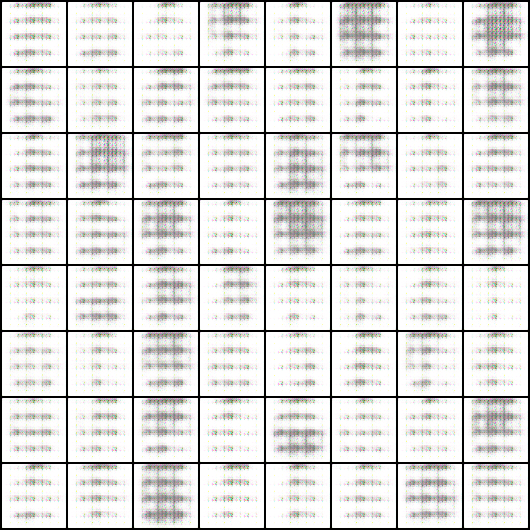

In [31]:
Image('./generated/generated-images-0013.png')

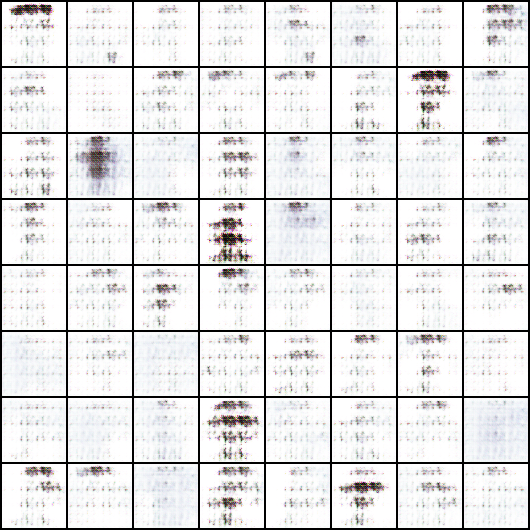

In [32]:
Image('./generated/generated-images-0037.png')

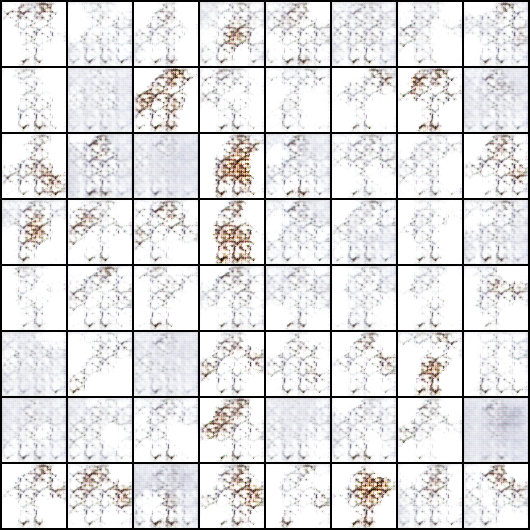

In [33]:
Image('./generated/generated-images-0072.png')

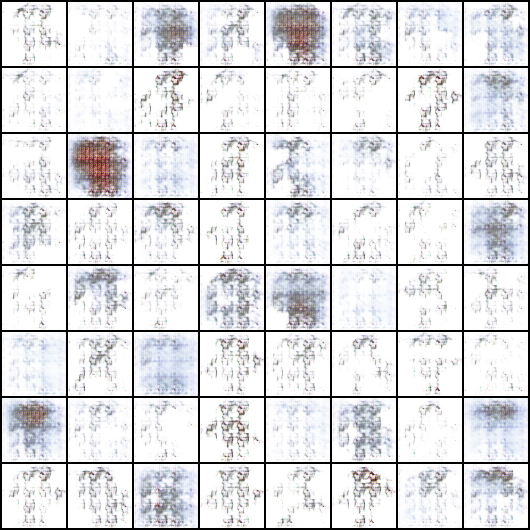

In [34]:
Image('./generated/generated-images-0103.png')

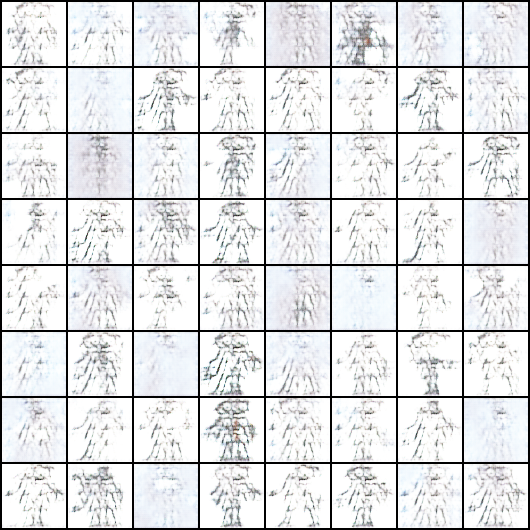

In [35]:
Image('./generated/generated-images-0138.png')

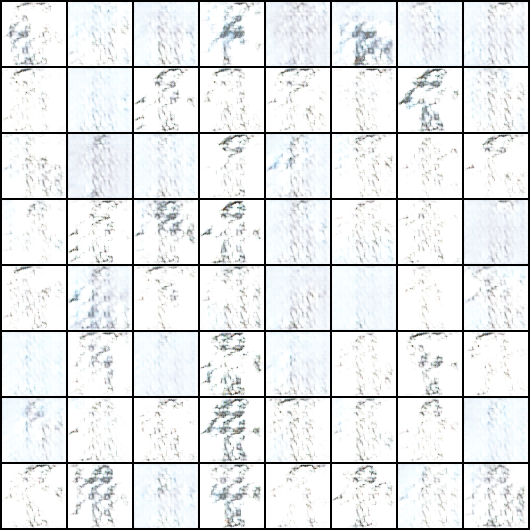

In [36]:
Image('./generated/generated-images-0147.png')

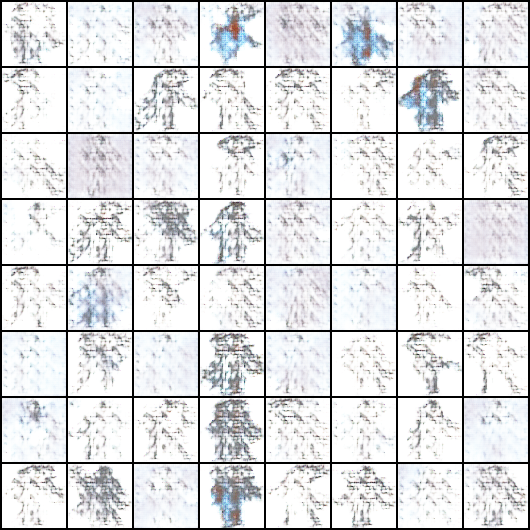

In [37]:
Image('./generated/generated-images-0150.png')

In [38]:
losses_g, losses_d, real_scores, fake_scores = history

In [40]:
loss_g=losses_g[-1]
loss_d=losses_d[-1]
real_score=real_scores[-1]
fake_score=fake_scores[-1]

In [41]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

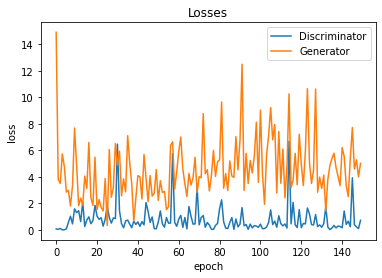

In [42]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

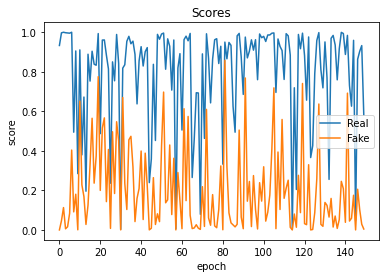

In [43]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');